# Trading Strategies powered by Machine Learning - Logistic Regression

## Logistic Regression with scikit-learn - a Simple Introduction

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from util.Save_result_return import save_to_csv

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use("seaborn-v0_8")

In [4]:
from backtesting import Strategy

## Getting the Data

In [5]:
XAUUSD = load_data()

In [6]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [7]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


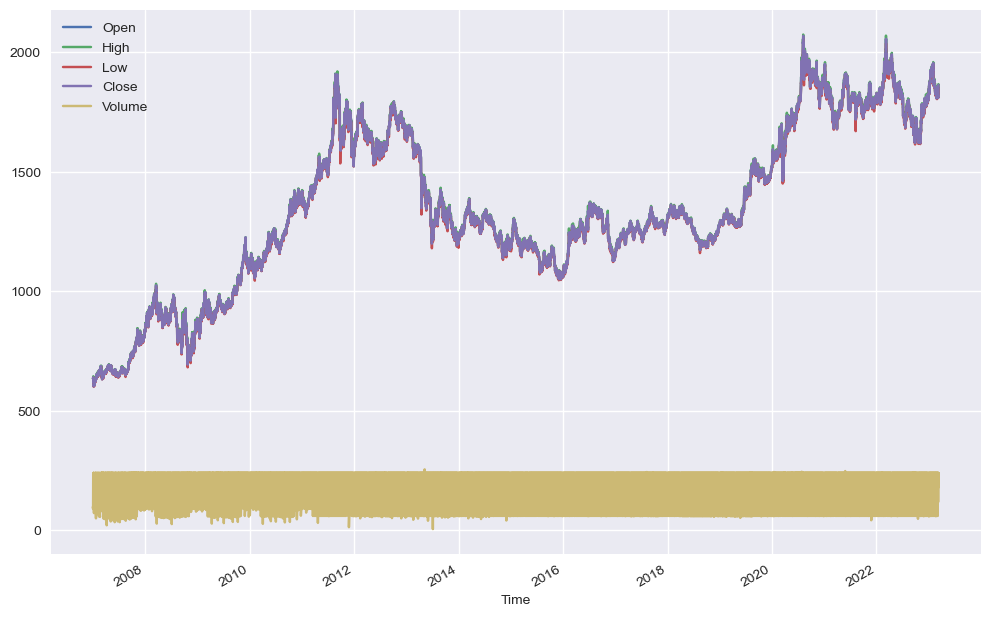

In [8]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [9]:
class Logistic_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position :
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)
            
        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

        

In [10]:
strategy = Logistic_Regression
account_size = 10000
folder_ML_Strategy = 'Logistic Regression'

In [11]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
from util.Save_result_return import save_to_csv
import sys
sys.path.append('../../')


plt.style.use("seaborn-v0_8")


class ML_Regression():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None

    def Prepare(self, lags=5):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        data["return_signal"] = data["returns"].shift(-1)
        data.dropna(inplace=True)
        data["direction"] = np.sign(data.return_signal)

        cols = []

        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        lm = LogisticRegression(C=1e6, max_iter=100000, multi_class="ovr")
        lm.fit(data[cols], data['direction'])
        data["pred"] = lm.predict(data[cols])
        data['pred'] = np.sign(data['pred'])


        self.model = lm
        self.data_train = data

    def Predict(self, lags=5):
        data = self.data.loc[self.start_test:self.end_test].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        cols = []

        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        data["pred"] = self.model.predict(data[cols])
        data['pred'] = np.sign(data['pred'])

        self.data_test = data

    def Backtest(self, data, account_size=10000):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1/100, commission=0.0002)
        result = backtest.run()
        return result


    def Run(self):
        self.Prepare()
        result_train = self.Backtest(self.data_train)
        
        self.Predict()
        result_test = self.Backtest(self.data_test)
        

        return result_train, result_test

## TF D1

In [12]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'D1'

In [13]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [14]:
train , test = ml.Run()

### In-Sample Backtesting

In [15]:
train

Start                     2007-01-08 00:00:00
End                       2019-12-30 00:00:00
Duration                   4739 days 00:00:00
Exposure Time [%]                   99.950556
Equity Final [$]                 10907.139169
Equity Peak [$]                  11083.388039
Return [%]                           9.071392
Buy & Hold Return [%]              148.689509
Return (Ann.) [%]                    0.542424
Volatility (Ann.) [%]                1.815235
Sharpe Ratio                         0.298818
Sortino Ratio                        0.413693
Calmar Ratio                         0.089708
Max. Drawdown [%]                   -6.046527
Avg. Drawdown [%]                   -0.320938
Max. Drawdown Duration     2643 days 00:00:00
Avg. Drawdown Duration       62 days 00:00:00
# Trades                                  683
Win Rate [%]                        57.393851
Best Trade [%]                       8.243991
Worst Trade [%]                    -13.413145
Avg. Trade [%]                    

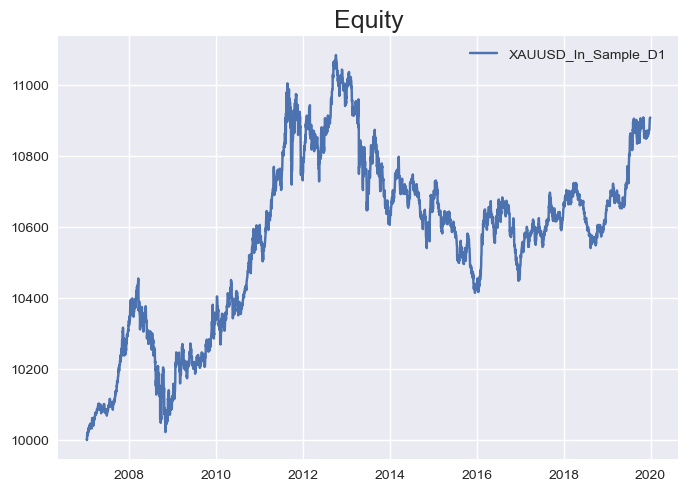

In [16]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [17]:
test

Start                     2020-01-08 00:00:00
End                       2023-03-10 00:00:00
Duration                   1157 days 00:00:00
Exposure Time [%]                   99.796954
Equity Final [$]                  9945.346222
Equity Peak [$]                  10400.391298
Return [%]                          -0.546538
Buy & Hold Return [%]               19.648007
Return (Ann.) [%]                    -0.14011
Volatility (Ann.) [%]                2.615742
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -7.499866
Avg. Drawdown [%]                   -0.832942
Max. Drawdown Duration      945 days 00:00:00
Avg. Drawdown Duration       81 days 00:00:00
# Trades                                  127
Win Rate [%]                        53.543307
Best Trade [%]                       6.298632
Worst Trade [%]                     -7.751037
Avg. Trade [%]                    

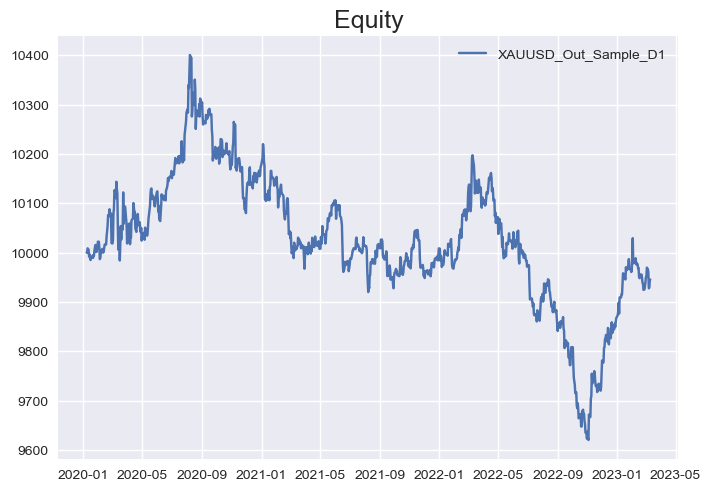

In [18]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [19]:
filename_train = f'result_{TF}_In_Sample.csv'

In [20]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [21]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [22]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H4

In [23]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H4'

In [24]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [25]:
train , test = ml.Run()

### In-Sample Backtesting

In [26]:
train

Start                     2007-01-02 00:00:00
End                       2019-12-31 16:00:00
Duration                   4746 days 16:00:00
Exposure Time [%]                   99.990414
Equity Final [$]                 10201.722846
Equity Peak [$]                  11552.817575
Return [%]                           2.017228
Buy & Hold Return [%]              138.448093
Return (Ann.) [%]                    0.125837
Volatility (Ann.) [%]                1.767034
Sharpe Ratio                         0.071214
Sortino Ratio                         0.09873
Calmar Ratio                         0.009551
Max. Drawdown [%]                  -13.174686
Avg. Drawdown [%]                   -0.197426
Max. Drawdown Duration     3073 days 12:00:00
Avg. Drawdown Duration       22 days 01:00:00
# Trades                                 6580
Win Rate [%]                        58.282675
Best Trade [%]                       6.707181
Worst Trade [%]                    -13.532554
Avg. Trade [%]                    

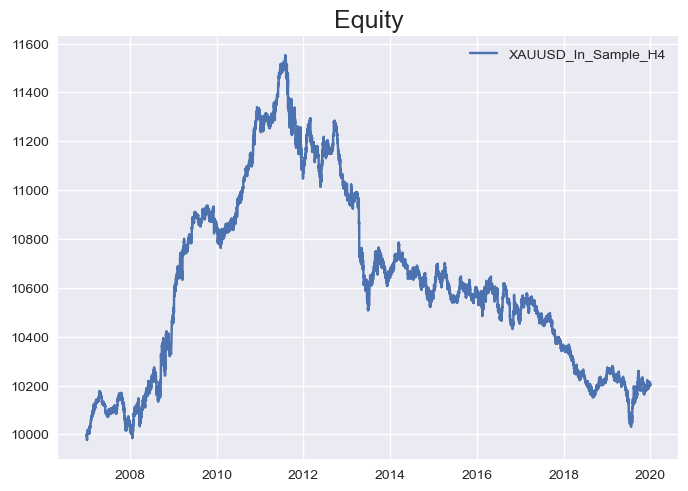

In [27]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [28]:
test

Start                     2020-01-02 20:00:00
End                       2023-03-10 16:00:00
Duration                   1162 days 20:00:00
Exposure Time [%]                   99.960777
Equity Final [$]                  9405.514802
Equity Peak [$]                  10173.405751
Return [%]                          -5.944852
Buy & Hold Return [%]               21.937846
Return (Ann.) [%]                   -1.547975
Volatility (Ann.) [%]                2.671756
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                    -7.97828
Avg. Drawdown [%]                   -0.694948
Max. Drawdown Duration      967 days 16:00:00
Avg. Drawdown Duration       50 days 11:00:00
# Trades                                 1589
Win Rate [%]                        58.527376
Best Trade [%]                       3.284787
Worst Trade [%]                     -4.669735
Avg. Trade [%]                    

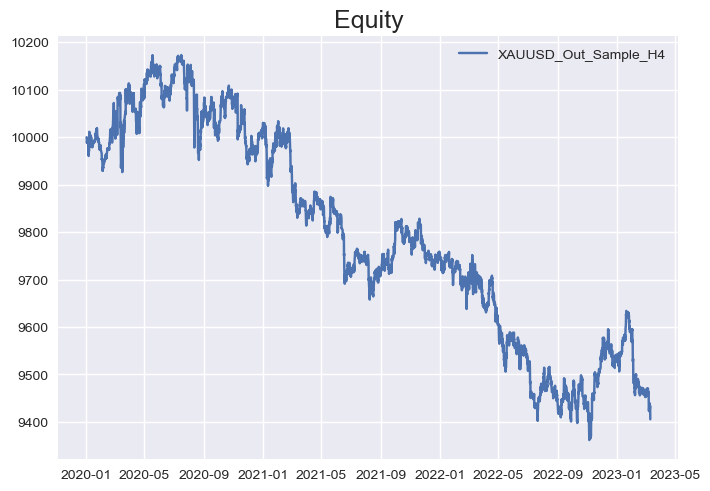

In [29]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [30]:
filename_train = f'result_{TF}_In_Sample.csv'

In [31]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [32]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [33]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H1

In [34]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H1'

In [35]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [36]:
train , test = ml.Run()

### In-Sample Backtesting

In [37]:
train

Start                     2007-01-01 06:00:00
End                       2019-12-31 20:00:00
Duration                   4747 days 14:00:00
Exposure Time [%]                   99.997471
Equity Final [$]                  5332.547997
Equity Peak [$]                  10000.896516
Return [%]                          -46.67452
Buy & Hold Return [%]              138.749634
Return (Ann.) [%]                   -3.835236
Volatility (Ann.) [%]                2.061984
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -47.052343
Avg. Drawdown [%]                  -23.528711
Max. Drawdown Duration     4747 days 07:00:00
Avg. Drawdown Duration     2373 days 17:00:00
# Trades                                28161
Win Rate [%]                         60.59799
Best Trade [%]                       3.428308
Worst Trade [%]                     -9.748547
Avg. Trade [%]                    

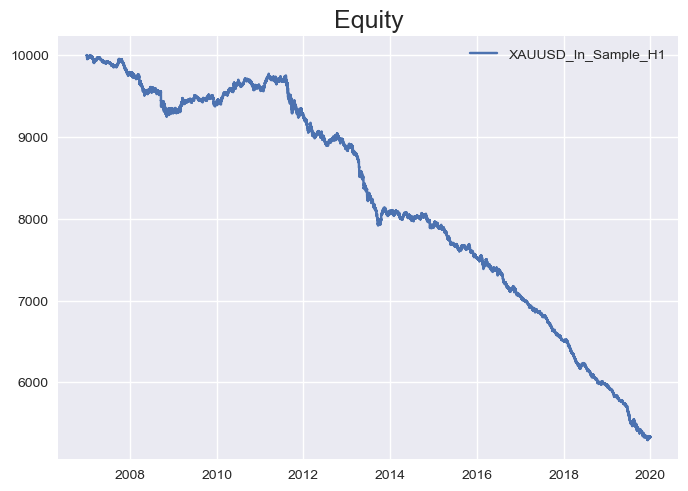

In [38]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [39]:
test

Start                     2020-01-02 05:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 12:00:00
Exposure Time [%]                   99.989394
Equity Final [$]                   8504.78965
Equity Peak [$]                  10268.944598
Return [%]                         -14.952104
Buy & Hold Return [%]               22.623102
Return (Ann.) [%]                   -4.031059
Volatility (Ann.) [%]                2.442698
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -17.916552
Avg. Drawdown [%]                   -0.500229
Max. Drawdown Duration      977 days 07:00:00
Avg. Drawdown Duration       22 days 18:00:00
# Trades                                 6640
Win Rate [%]                        60.662651
Best Trade [%]                       3.273433
Worst Trade [%]                     -5.012371
Avg. Trade [%]                    

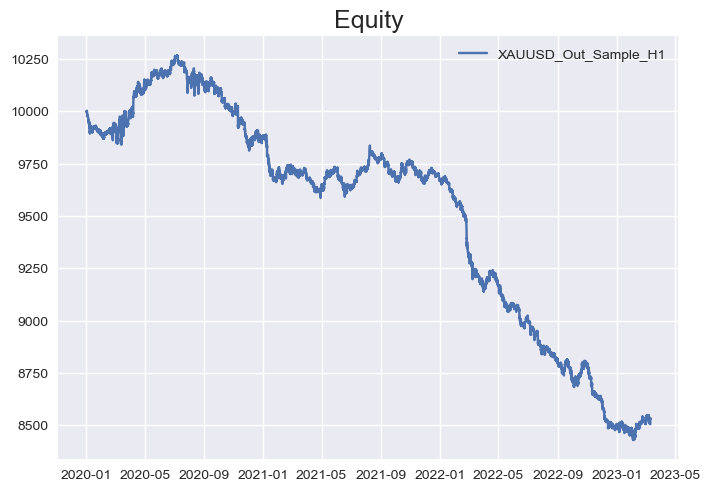

In [40]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [41]:
filename_train = f'result_{TF}_In_Sample.csv'

In [42]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [43]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [44]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M30

In [45]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M30'

In [46]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [47]:
train , test = ml.Run()

### In-Sample Backtesting

In [48]:
train

Start                     2007-01-01 03:00:00
End                       2019-12-31 21:00:00
Duration                   4747 days 18:00:00
Exposure Time [%]                   95.316607
Equity Final [$]                     4.881197
Equity Peak [$]                  10001.702504
Return [%]                         -99.951188
Buy & Hold Return [%]              138.820778
Return (Ann.) [%]                  -37.762255
Volatility (Ann.) [%]               17.787449
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.961495
Avg. Drawdown [%]                  -24.993015
Max. Drawdown Duration     4747 days 12:00:00
Avg. Drawdown Duration     1186 days 22:08:00
# Trades                                52893
Win Rate [%]                        58.054941
Best Trade [%]                       3.207378
Worst Trade [%]                     -9.600389
Avg. Trade [%]                    

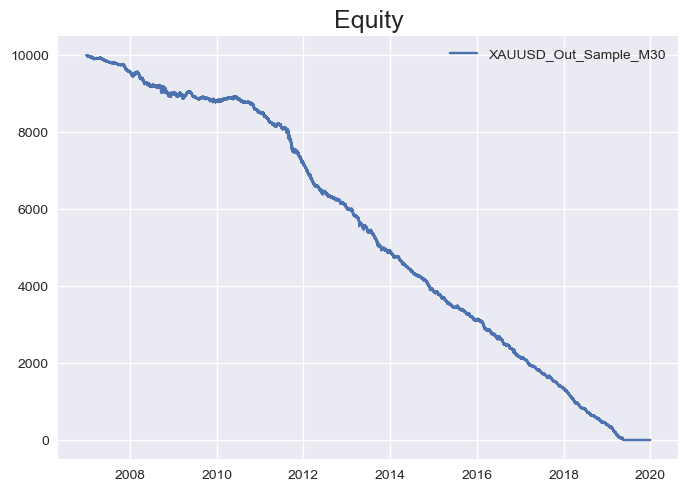

In [49]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [50]:
test

Start                     2020-01-02 02:00:00
End                       2023-03-10 17:30:00
Duration                   1163 days 15:30:00
Exposure Time [%]                   99.994696
Equity Final [$]                  7104.506222
Equity Peak [$]                  10003.136998
Return [%]                         -28.954938
Buy & Hold Return [%]                22.67717
Return (Ann.) [%]                   -8.336031
Volatility (Ann.) [%]                2.621333
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -29.690068
Avg. Drawdown [%]                   -5.955898
Max. Drawdown Duration     1163 days 01:30:00
Avg. Drawdown Duration      232 days 17:06:00
# Trades                                13223
Win Rate [%]                        59.215004
Best Trade [%]                       1.898097
Worst Trade [%]                     -4.855696
Avg. Trade [%]                    

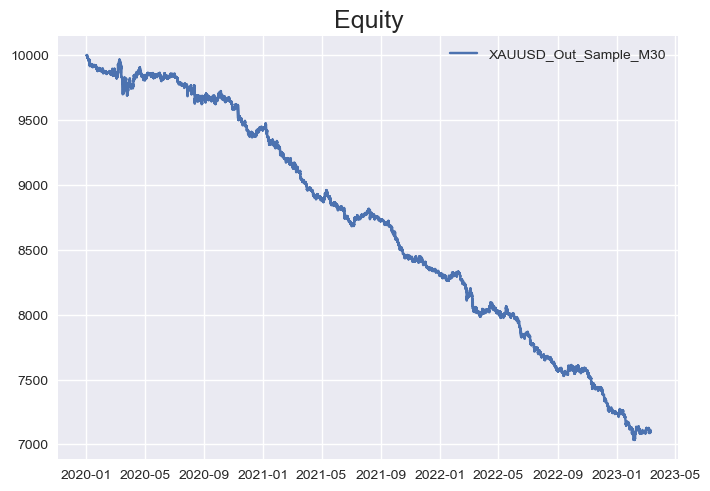

In [51]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [52]:
filename_train = f'result_{TF}_In_Sample.csv'

In [53]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [54]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [55]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M15

In [56]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M15'

In [57]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [58]:
train , test = ml.Run()

### In-Sample Backtesting

In [59]:
train

Start                     2014-09-23 14:30:00
End                       2019-12-31 21:30:00
Duration                   1925 days 07:00:00
Exposure Time [%]                   99.698147
Equity Final [$]                    10.101061
Equity Peak [$]                  10003.817421
Return [%]                         -99.898989
Buy & Hold Return [%]               24.218093
Return (Ann.) [%]                   -65.35172
Volatility (Ann.) [%]                11.99189
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.905326
Avg. Drawdown [%]                  -19.988681
Max. Drawdown Duration     1925 days 00:45:00
Avg. Drawdown Duration      385 days 01:12:00
# Trades                                43782
Win Rate [%]                        51.285917
Best Trade [%]                       2.383882
Worst Trade [%]                     -4.492079
Avg. Trade [%]                    

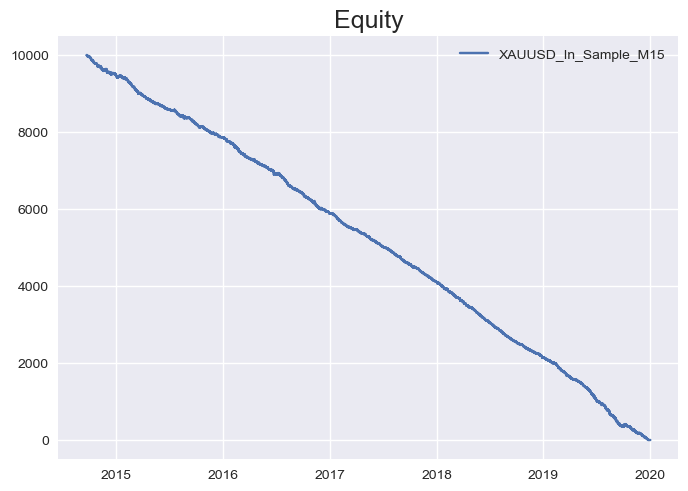

In [60]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [61]:
test

Start                     2020-01-02 00:30:00
End                       2023-03-10 17:45:00
Duration                   1163 days 17:15:00
Exposure Time [%]                   99.997348
Equity Final [$]                  2413.022555
Equity Peak [$]                  10000.226279
Return [%]                         -75.869774
Buy & Hold Return [%]               22.768468
Return (Ann.) [%]                  -30.347462
Volatility (Ann.) [%]                3.201177
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -75.931841
Avg. Drawdown [%]                  -75.931841
Max. Drawdown Duration     1163 days 16:45:00
Avg. Drawdown Duration     1163 days 16:45:00
# Trades                                26578
Win Rate [%]                        55.188502
Best Trade [%]                       2.034952
Worst Trade [%]                     -5.137612
Avg. Trade [%]                    

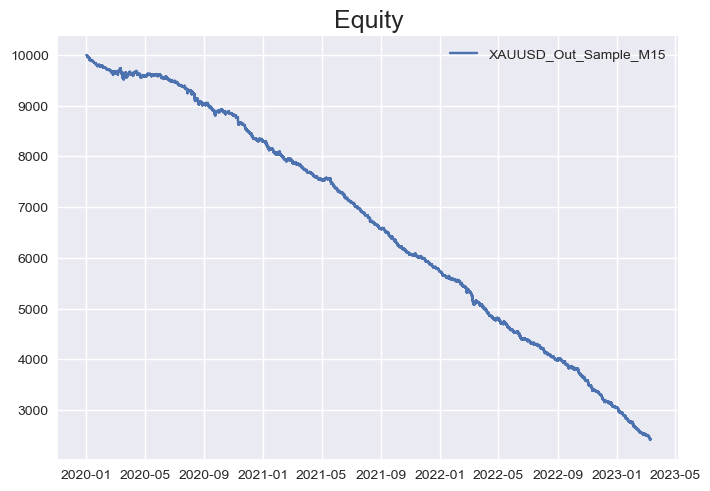

In [62]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [63]:
filename_train = f'result_{TF}_In_Sample.csv'

In [64]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M5

In [ ]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M5'

In [ ]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [ ]:
train , test = ml.Run()

### In-Sample Backtesting

In [ ]:
train

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M1

In [ ]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M1'

In [ ]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [ ]:
train , test = ml.Run()

### In-Sample Backtesting

In [ ]:
train

In [ ]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [ ]:
test

In [ ]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [ ]:
filename_train = f'result_{TF}_In_Sample.csv'

In [ ]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')